In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import compress

import datetime
from dateutil.parser import parse

import math
import os
import copy
import pickle

import drugLookup

In [2]:
# Read in data (from pickle file)
file = open('train_set_filtered','rb')
train_set = pickle.load(file)

file = open('test_set_filtered','rb')
test_set = pickle.load(file)

In [3]:
train_set.to_csv('train_set.csv')

In [4]:
d_train = list(train_set['drug_prediction'])
v_train = list(train_set['vendor_name'])

d_test = list(test_set['drug_prediction'])
v_test = list(test_set['vendor_name'])

## Compute $P(d~|~v)$

In [5]:
# Function gets tally of drugs sold for given vendor
def getDrugsForVendor(vendor_name):
#     Args: Name of a vendor (string)
#     Returns: series, representing proportion of total for each drug
    vendor_subset = train_set[train_set['vendor_name'] == vendor_name]
    vendor_drug_tally = vendor_subset['drug_prediction'].groupby(vendor_subset['drug_prediction']).count()
    return(vendor_drug_tally/np.sum(vendor_drug_tally))

In [6]:
# Get list of vendors in the data frame
_ , vendor_list = pd.factorize(v_train, sort = True)

# Factorize drug_predictions
_ , drug_list = pd.factorize(d_train, sort = True)

In [7]:
#Create emission probability dataframe
pdv = pd.DataFrame(columns = drug_list)
#Insert vendor name column
pdv.insert(0, "Vendor Name", vendor_list)
# Apply function to dataframe
pdv.iloc[:,1:] = pdv['Vendor Name'].apply(getDrugsForVendor)
# Sort by Vendor name and fill NA values with 0
pdv = pdv.fillna(0)
# Set index to be vendor name
pdv = pdv.set_index('Vendor Name')

## Compute $P(t~|~v)$

In [8]:
from datetime import datetime, date, time, timedelta

def addTimes(start_time, duration):
    # Function to add minutes to datetime.time() object
    dt = datetime.combine(date.today(), start_time) # create arbitrary date
    return((dt + timedelta(minutes = duration)).time())

#  Function to check if time is in a time interval
def timeInInterval(start_time, duration, check_time):
    end_time = addTimes(start_time, duration)
    cond1 = start_time <= check_time
    cond2 = check_time < end_time
    return(cond1 and cond2)

In [9]:
# Create list of time intervals
# Get list of interval start dates
start = time(0,0,0,0) # first interval start date
interval = 15 # length of interval (minutes)
n_intervals = int(24*60/interval) # compute number of intervals in 24 hour period
slide_amount = interval # amount to slide window (if no overlap desired, set equal to interval)

# Get all intervals in 24 hour period
interval_starts = [addTimes(start_time = start, duration = slide_amount * n) for n in range(n_intervals)]

In [10]:
# Function to classify given time into one of given bins
def binTime(time1, duration, start_times):
    time_bin = [start_time for start_time in start_times if timeInInterval(start_time, duration, time1.time())]
    if len(time_bin) == 0:
        return(start_times[-1])
    else:
        return(time_bin[0])
        
# For given vendor, count the number of transactions in each time_bin
train_set['time_bin'] = train_set['date'].apply(binTime, duration = 15, start_times = interval_starts)
test_set['time_bin'] = test_set['date'].apply(binTime, duration = 15, start_times = interval_starts)

## Plots

In [141]:
from datetime import datetime, date, time, timedelta
i = 0
# for group in train_set.groupby('time_bin'):
#     print(group.groupby('vendor_name').count())
# for group in train_set.groupby(['time_bin', 'vendor_name']).groups:
#     print(group)
d = train_set.groupby(['time_bin', 'vendor_name'])['vendor_name'].count()
# for thing in d:
#     print(thing)
# d.index
d

time_bin  vendor_name         
01:15:00  BuddyBLAZE               77
          Tollense-2               24
          highrollers              54
01:45:00  Discover                 70
          Gladyman                 39
          Port-Royal                6
          ScarlettsK               78
          clawedfeats              69
          largomonkey              60
          mailordermary2            4
          philppplein              19
          puremedicinehouse        90
          rickandmortyshop         84
          tonystarkweed            18
02:00:00  BlackSheepSquadron       75
          Grenouillebleu            2
          dankcity                 48
          trotters_stash           82
02:30:00  Perfect.Shrooms          69
          StealthPharmacy          82
03:00:00  24-7SmokeShop            27
          ChemicalConnection       99
          Express247                1
          Only_dmt_from_tj          1
          PleasureIsland          107
          RoyalMail

In [154]:
temp = pd.concat([train_set, test_set.iloc[:,:-1]])
# print(train_set.head())
# print(test_set.iloc[:,:-1].head())
temp.groupby('vendor_name').count().sort_values(by = 'drug_prediction', ascending = False)

,date,drug_prediction,time_bin
vendor_name,,,
StealthPharmacy,385,385,385
bangalow,375,375,375
MoonBanana,373,373,373
blueviking,342,342,342
MercenaryGB,333,333,333
Gladyman,329,329,329
Qualitywhitee,322,322,322
DDUK-NDD,319,319,319
Perfect.Shrooms,317,317,317


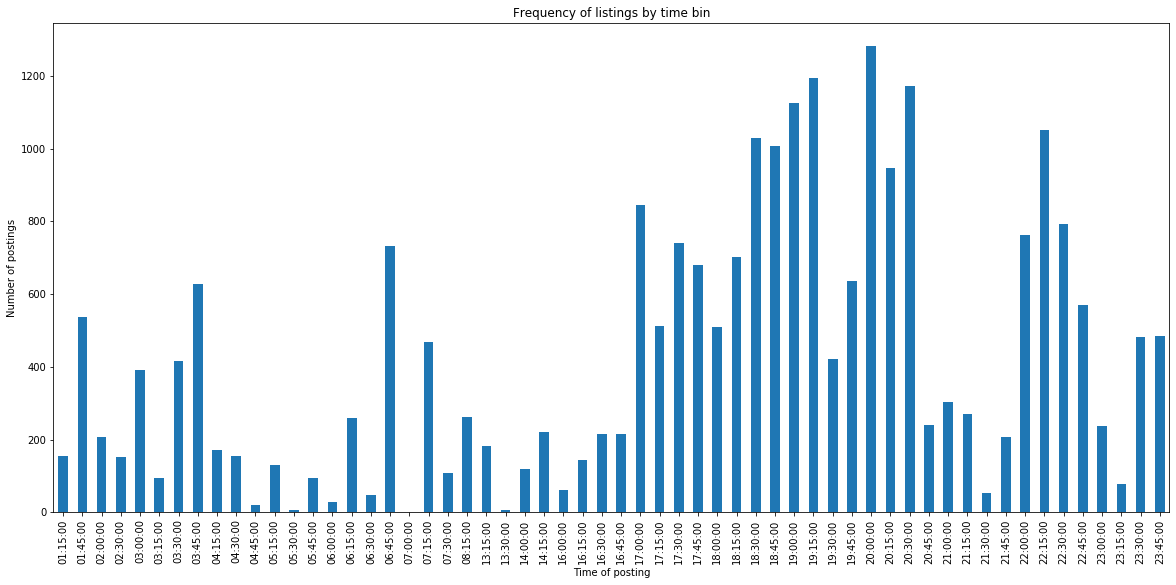

In [143]:
# Plotting listings by time
plt.figure(figsize = (20,9))
train_set['time_bin'].value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Time of posting')
plt.ylabel('Number of postings')
plt.title('Frequency of listings by time bin')
plt.show()

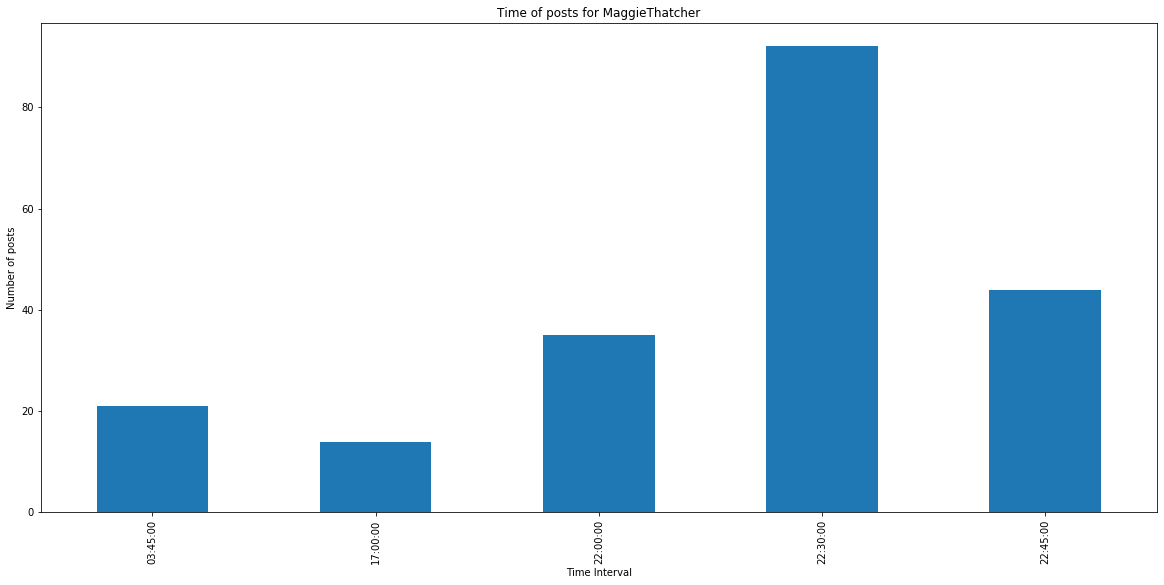

In [142]:
# Plotting listings by time for one vendor
vendor = 'MaggieThatcher'
plt.figure(figsize = (20,9))
train_set[train_set.vendor_name == vendor]['time_bin'].value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Time Interval')
plt.ylabel('Number of posts')
plt.title('Time of posts for '+vendor)
plt.show()

In [13]:
# Plot number of time bins for each vendor

In [14]:
# Get times for vendor
# Function gets tally of transactions for given vendor in each time interval
def getTimesForVendor(vendor_name):
#     Args: Name of a vendor (string)
#     Returns: series, representing proportion of total for each drug
    vendor_subset = train_set[train_set['vendor_name'] == vendor_name]
    vendor_drug_tally = vendor_subset['time_bin'].groupby(vendor_subset['time_bin']).count()
    return(vendor_drug_tally/np.sum(vendor_drug_tally))

In [15]:
#Create emission probability dataframe for time values
ptv = pd.DataFrame(columns = interval_starts)
#Insert vendor name column
ptv.insert(0, "Vendor Name", vendor_list)
# Apply function to dataframe
ptv.iloc[:,1:] = ptv['Vendor Name'].apply(getTimesForVendor)
# Sort by Vendor name and fill NA values with 0
ptv = ptv.fillna(0)
# Set index to be vendor name
ptv = ptv.set_index('Vendor Name')

In [40]:
ptv

,00:00:00,00:15:00,00:30:00,00:45:00,01:00:00,01:15:00,01:30:00,01:45:00,02:00:00,02:15:00,...,21:30:00,21:45:00,22:00:00,22:15:00,22:30:00,22:45:00,23:00:00,23:15:00,23:30:00,23:45:00
Vendor Name,,,,,,,,,,,,,,,,,,,,,
24-7SmokeShop,0,0,0,0,0,0.000000,0,0.000000,0.000000,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
420HighStreet,0,0,0,0,0,0.000000,0,0.000000,0.000000,0,...,0.000000,0.000000,0.000000,0.038168,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9incecloud,0,0,0,0,0,0.000000,0,0.000000,0.000000,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.644928,0.000000,0.000000,0.000000,0.000000
A1CRACK,0,0,0,0,0,0.000000,0,0.000000,0.000000,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Alagbada726,0,0,0,0,0,0.000000,0,0.000000,0.000000,0,...,0.000000,0.000000,0.008929,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AlanCuring420_UK,0,0,0,0,0,0.000000,0,0.000000,0.000000,0,...,0.000000,0.000000,0.000000,0.000000,0.204082,0.000000,0.000000,0.000000,0.000000,0.000000
Americansteroids,0,0,0,0,0,0.000000,0,0.000000,0.000000,0,...,0.000000,0.000000,0.000000,0.000000,0.585185,0.000000,0.000000,0.000000,0.000000,0.000000
Aphelion,0,0,0,0,0,0.000000,0,0.000000,0.000000,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BlackSheepSquadron,0,0,0,0,0,0.000000,0,0.000000,0.365854,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Train Naïve-Bayes classifier

In [16]:
# Get prior probabilities (i.e., probability of each vendor)
vendor_probs = train_set['vendor_name'].value_counts()/np.sum(train_set['vendor_name'].value_counts())
vendor_probs = vendor_probs.sort_index()
print(ptv.shape)
print(pdv.shape)
print(vendor_probs.shape)

(190, 96)
(190, 15)
(190,)


In [17]:
# Convert dataframes to matrices
ptv_ar = np.array(ptv)
pdv_ar = np.array(pdv)

# Convert vendor_probs to vector in R^3
vendor_probs_ar = np.array(vendor_probs).reshape(1,1,-1)

# Multiply the conditional probability arrays and multiply by vendor_probability matrix
temp1 = np.matmul(ptv_ar.transpose(), pdv_ar) # multiply matrices
temp2 = np.expand_dims(temp1, axis = 2) # add third dimension to matrix

# Compute conditional probability (don't need to divide by joint probability of drug, time)
pvdt1 = np.matmul(temp2, vendor_probs_ar) # multiply vector along third dimension of the matrix

In [18]:
# Check pvdt by doing for-loop
pvdt2 = -1 * np.ones([len(interval_starts), len(drug_list), len(vendor_list)])
for v_idx, vendor in enumerate(vendor_list):
    for d_idx, drug in enumerate(drug_list):
        for t_idx, start_time in enumerate(interval_starts):
            pvdt2[t_idx, d_idx, v_idx] = ptv.loc[vendor, start_time] * pdv.loc[vendor, drug] * vendor_probs[vendor]
#             pvdt2[t_idx, d_idx, v_idx] = np.log(ptv.loc[vendor, start_time]) + \
#                                          np.log(pdv.loc[vendor, drug]) + \
#                                          np.log(vendor_probs[vendor])
            

In [43]:
pvdt2.shape

(96, 15, 190)

In [41]:
vendor_probs

24-7SmokeShop           0.004317
420HighStreet           0.005335
9incecloud              0.005620
A1CRACK                 0.006394
Alagbada726             0.004562
AlanCuring420_UK        0.007983
Americansteroids        0.005498
Aphelion                0.004521
BlackSheepSquadron      0.008349
Boliko                  0.005620
BudWorld                0.007372
BuddyBLAZE              0.005946
CalSource               0.004521
CaliCartel              0.003218
CaliDrugCo              0.008919
CaptainPirate           0.005213
Cash_King               0.005376
ChemicalConnection      0.007209
ChillChem               0.006476
Cocaineandbrandy        0.007250
CryptoICE               0.002932
DCdutchconnectionUK     0.006639
DDUK-NDD                0.006924
DMT-lovestore           0.005539
DOPE_CHEF               0.004724
DRUGPOOL                0.004928
Dame2Pique              0.002444
DerSandmann             0.001711
Discover                0.003584
DispensaryDash          0.003299
          

In [51]:
print(np.sum(pvdt2[:,:,3]))

0.006394330631694701


In [50]:
vendor_probs

24-7SmokeShop           0.004317
420HighStreet           0.005335
9incecloud              0.005620
A1CRACK                 0.006394
Alagbada726             0.004562
AlanCuring420_UK        0.007983
Americansteroids        0.005498
Aphelion                0.004521
BlackSheepSquadron      0.008349
Boliko                  0.005620
BudWorld                0.007372
BuddyBLAZE              0.005946
CalSource               0.004521
CaliCartel              0.003218
CaliDrugCo              0.008919
CaptainPirate           0.005213
Cash_King               0.005376
ChemicalConnection      0.007209
ChillChem               0.006476
Cocaineandbrandy        0.007250
CryptoICE               0.002932
DCdutchconnectionUK     0.006639
DDUK-NDD                0.006924
DMT-lovestore           0.005539
DOPE_CHEF               0.004724
DRUGPOOL                0.004928
Dame2Pique              0.002444
DerSandmann             0.001711
Discover                0.003584
DispensaryDash          0.003299
          

In [20]:
# print(pvdt1)
print(np.sum(pvdt2[:,:,10]))

0.007371807925711725


## Evaluate Naïve-Bayes classifier

In [29]:
# Function to get list of indices with max value
def multi_argmax(v, n):
#     v is vector 
#     n is number of maximum indices to return
    max_indices = []
    temp = copy.deepcopy(v)
    while len(max_indices) < n:
        max_idx = np.argmax(temp)
        max_indices.append(max_idx)
        temp[max_idx] = -1
    return(max_indices)

In [34]:
pvdt_dict = dict()
for t_idx, time_bin in enumerate(interval_starts):
    for d_idx, drug in enumerate(drug_list):
#         pvdt_dict[(time_bin , drug)] = vendor_list[np.argmax(pvdt2[t_idx, d_idx])]
        pvdt_dict[(time_bin , drug)] = vendor_list[multi_argmax(pvdt2[t_idx, d_idx], 10)]

In [52]:
pvdt_dict

{(datetime.time(0, 0),
  'amphetamine'): array(['24-7SmokeShop', '420HighStreet', '9incecloud', 'A1CRACK',
        'Alagbada726', 'AlanCuring420_UK', 'Americansteroids', 'Aphelion',
        'BlackSheepSquadron', 'Boliko'], dtype=object),
 (datetime.time(0, 0),
  'benzodiazepines'): array(['24-7SmokeShop', '420HighStreet', '9incecloud', 'A1CRACK',
        'Alagbada726', 'AlanCuring420_UK', 'Americansteroids', 'Aphelion',
        'BlackSheepSquadron', 'Boliko'], dtype=object),
 (datetime.time(0, 0),
  'buprenorphine'): array(['24-7SmokeShop', '420HighStreet', '9incecloud', 'A1CRACK',
        'Alagbada726', 'AlanCuring420_UK', 'Americansteroids', 'Aphelion',
        'BlackSheepSquadron', 'Boliko'], dtype=object),
 (datetime.time(0, 0),
  'cocaine'): array(['24-7SmokeShop', '420HighStreet', '9incecloud', 'A1CRACK',
        'Alagbada726', 'AlanCuring420_UK', 'Americansteroids', 'Aphelion',
        'BlackSheepSquadron', 'Boliko'], dtype=object),
 (datetime.time(0, 0),
  'dmt'): array(['24-7S

In [35]:
# Get testing examples 
t_test = list(test_set['time_bin'])
td_test = list(zip(t_test, d_test))

In [36]:
# Function to predict class for each drug in test set
def bayesPredict(obs_seq):
    preds = [pvdt_dict[obs] for obs in obs_seq]
    return(preds)

test_set['vendor_pred'] = bayesPredict(td_test)

In [38]:
# Compute 'top n' accuracy
def get_top_n(df, n):
    q = zip(df['vendor_name'], df['vendor_pred'])
    if n == 1:
        ar = [samp[0] == samp[1][0] for samp in q]
    else:
        ar = [samp[0] in samp[1][:n] for samp in q]
    acc = np.sum(ar)/len(ar)
    return(round(acc,4))

In [39]:
print('Top 1 accuracy :',get_top_n(test_set, 1))
print('Top 2 accuracy :',get_top_n(test_set, 2))
print('Top 3 accuracy :',get_top_n(test_set, 3))
print('Top 5 accuracy :',get_top_n(test_set, 5))
print('Top 10 accuracy:',get_top_n(test_set, 10))

Top 1 accuracy : 0.6217
Top 2 accuracy : 0.8453
Top 3 accuracy : 0.9302
Top 5 accuracy : 0.9894
Top 10 accuracy: 0.9927
